In [20]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import pickle

import torch
import torch.nn.functional as F

from transformers import (
    BertTokenizer, 
    BertForMaskedLM,
    AdamW
)

import time
import IPython.display as ipd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm

# constant

In [2]:
EPOCHS = 2
BATCH_SIZE = 2**3
LR = 5e-5
DEVICE = 'cuda' if torch.cuda.is_available else 'cpu'
PRE_BERT = 'allenai/scibert_scivocab_cased'

print('EPOCHS', EPOCHS)
print('BATCH_SIZE', BATCH_SIZE)
print('LR', LR)
print('DEVICE', DEVICE)
print('PRE_BERT', PRE_BERT)

EPOCHS 2
BATCH_SIZE 8
LR 5e-05
DEVICE cuda
PRE_BERT allenai/scibert_scivocab_cased


# data

In [3]:
with open('../data/emnlp2022.pkl', 'rb') as f:
    papers = pickle.load(f)
    
titles = sorted(papers.keys())
    
sentences = [t+' '+papers.get(t) for t in titles]

In [4]:
tokenizer = BertTokenizer.from_pretrained(PRE_BERT)

In [5]:
inputs = tokenizer(
    sentences, 
    truncation_strategy='do_not_truncate',
    pad_to_max_length=True,
    return_tensors='pt'
)

inputs['labels'] = inputs.input_ids.detach().clone()

rand = torch.rand(inputs.input_ids.shape)
mask_arr = rand < .15
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * (inputs.input_ids != 102)
selection = torch.flatten((mask_arr[0]).nonzero()).tolist()
inputs.input_ids[0, selection] = tokenizer.mask_token_id

lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2291: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [6]:
class MyDataSet(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    
    def __len__(self):
        return len(self.encodings.input_ids)
    
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    
dataset = MyDataSet(inputs)
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)

# model

In [7]:
model = BertForMaskedLM.from_pretrained(PRE_BERT)
model.to(DEVICE)
'DONE'

Some weights of the model checkpoint at allenai/scibert_scivocab_cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'DONE'

# train

In [8]:
optim = AdamW(model.parameters(), lr=LR)

lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [9]:
def train():
    loss_list = list()

    for e in range(EPOCHS):
        e_start = time.time()

        for i, d in enumerate(dataloader):
#             b_start = time.time()
            optim.zero_grad()

            input_ids = d.get('input_ids').to(DEVICE)
            attention_mask = d.get('attention_mask').to(DEVICE)
            labels = d.get('labels').to(DEVICE)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            loss_list.append(loss.item())
            loss.backward()
            optim.step()

        ipd.clear_output(wait=True)
#         print(f"{i+1}/{len(dataloader)}-th")
        print(f"batch {e+1}/{EPOCHS} EPOCH")
        print(f"{time.time()-e_start:.2f} sec/epoch")
#         print(f"{time.time()-b_start:.2f} sec/batch")
        plt.figure(figsize=(10, 2))
        plt.plot(loss_list)
        plt.title(f"{loss_list[-1]:.4f}")
        plt.show()

batch 2/2 EPOCH
42.54 sec/epoch


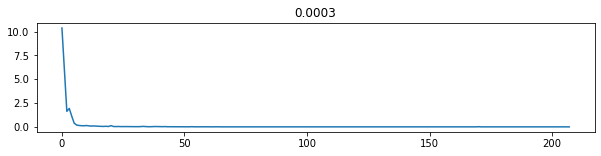

In [10]:
# train()

In [11]:
# o = model.bert(inputs.get('input_ids')[:1].to(DEVICE))[0][0, 0].cpu().detach()
# t = F.tanh(o)
# plt.figure(figsize=(20,3))
# plt.plot(o.numpy(), label='original')
# plt.plot(t.numpy(), label='tanh', alpha=.75)
# plt.legend()
# plt.show()

In [12]:
# torch.save(model.bert.state_dict(), '../my_ckpt/emnlpbert')

In [13]:
# model.bert.load_state_dict(torch.load('../my_ckpt/emnlpbert'))

# clustering

In [22]:
def get_hiddens():
    hiddens = []
    for i in tqdm(range(len(inputs.get('labels')))):
        input_ids = inputs.get('labels')[i:i+1].to(DEVICE)
        o = model.bert(input_ids)[0]
        o = F.tanh(o[0, 0])
        hiddens.append(o.detach().cpu().numpy())

    return hiddens

hiddens = get_hiddens()
len(hiddens)

  0%|          | 0/825 [00:00<?, ?it/s]

825

In [23]:
from sklearn.cluster import KMeans as Cluster
import numpy as np

In [41]:
n_clusters = 100

In [38]:
cluster = Cluster(n_clusters=n_clusters, random_state=0)

In [39]:
cluster.fit(hiddens)

KMeans(n_clusters=100, random_state=0)

In [48]:
for n in range(n_clusters):
    with open(f'../cluster/emnlp2022/{n:02d}.txt', 'wt') as f:
        indices = np.where(cluster.labels_==n)
        for idx in indices[0]:
            f.write('='*100)
            f.write('\n')
            t = titles[idx]
            f.write(t+'\n'+'\t'+papers.get(t))
            f.write('\n')